# Basic exploration of the Negative Binomial distribution

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from time import time

import janitor
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm

In [3]:
notebook_tic = time()
_ = gg.theme_set(gg.theme_classic())

In [4]:
def sample_pm_nb(mu: float, alpha: float, n: int = 500) -> np.ndarray:
    with pm.Model():
        x = pm.NegativeBinomial(name="x", mu=mu, alpha=alpha).random(size=n)
    return x

In [5]:
def sample_nb_with_params(
    params: list[tuple[float, float]], n: int = 500
) -> pd.DataFrame:
    dfs: list[pd.DataFrame] = []
    for mu, alpha in params:
        df = pd.DataFrame(
            {"mu": mu, "alpha": alpha, "draw": sample_pm_nb(mu, alpha, n=n)}
        )
        dfs.append(df)
    nb_samples = pd.concat(dfs)
    return nb_samples


def make_nb_counts_dataframe(
    params: list[tuple[float, float]], n: int = 500
) -> pd.DataFrame:
    nb_samples = sample_nb_with_params(params, n)
    nb_samples_counts = (
        nb_samples.value_counts(["mu", "alpha", "draw"])
        .to_frame("count")
        .reset_index(drop=False)
        .assign(label=lambda d: [f"mu: {m} alpha: {a}" for m, a in zip(d.mu, d.alpha)])
    )
    return nb_samples_counts

In [6]:
def plot_nb_sample_count(df: pd.DataFrame) -> gg.ggplot:
    return (
        gg.ggplot(df, gg.aes(x="draw", y="count", color="label"))
        + gg.geom_line(alpha=0.5)
        + gg.geom_point()
    )

Same parameters as used in the example in the PyMC3 documentation: [`NegativeBinomial`](https://docs.pymc.io/en/stable/api/distributions/discrete.html#pymc3.distributions.discrete.NegativeBinomial)

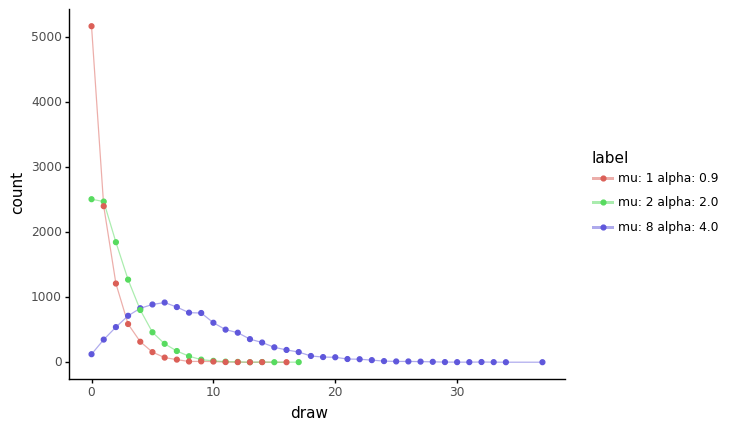

<ggplot: (357817001)>

In [7]:
params: list[tuple[float, float]] = [(1, 0.9), (2, 2), (8, 4)]
plot_nb_sample_count(make_nb_counts_dataframe(params, n=10000))

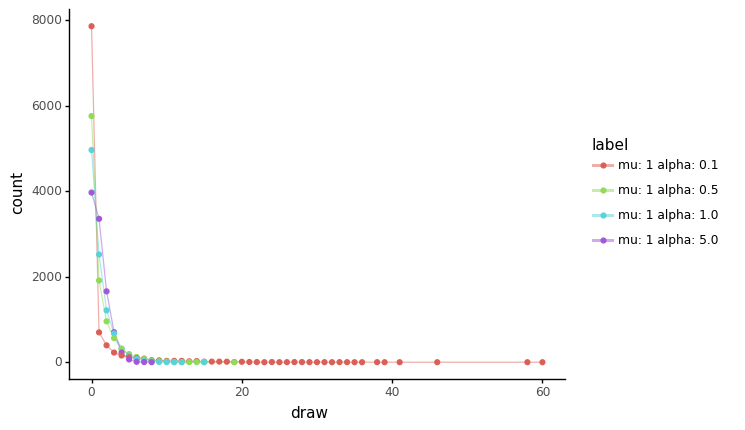

<ggplot: (358396754)>

In [8]:
params = [(1, 0.1), (1, 0.5), (1, 1.0), (1, 5.0)]
plot_nb_sample_count(make_nb_counts_dataframe(params, n=10000))

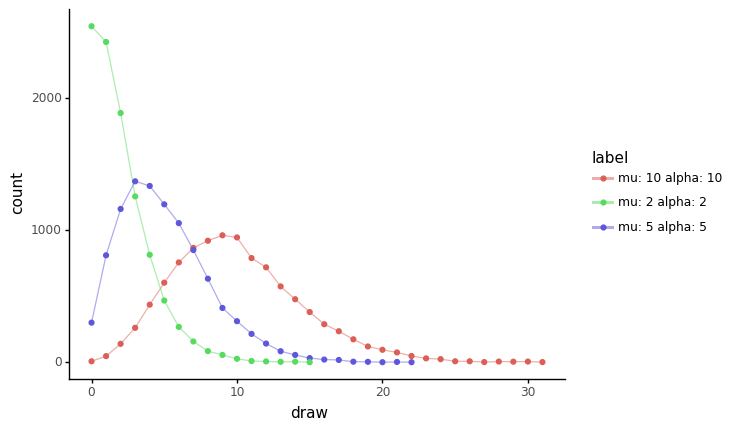

<ggplot: (358630605)>

In [9]:
params = [(2, 2), (5, 5), (10, 10)]
plot_nb_sample_count(make_nb_counts_dataframe(params, n=10000))

In [10]:
sample_nb_with_params([(1, 0.9), (2, 2), (8, 4)], n=100000).groupby(
    ["mu", "alpha"]
).agg(["mean", "std"])

draw          
             mean       std
mu alpha                   
1  0.9    1.00374  1.453233
2  2.0    1.99609  2.004434
8  4.0    8.00464  4.910961

In [11]:
make_nb_counts_dataframe([(0, 0.9)])

,mu,alpha,draw,count,label
0,0,0.9,0,500,mu: 0 alpha: 0.9


---

In [12]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 0.83 minutes


In [13]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-11-05

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.26.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 20.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac.local

Git branch: sp9

pandas  : 1.3.2
plotnine: 0.8.0
pymc3   : 3.11.2
janitor : 0.21.0
numpy   : 1.21.2
sys     : 3.9.6 | packaged by conda-forge | (default, Jul 11 2021, 03:36:15) 
[Clang 11.1.0 ]

